# <div style="text-align: center">Идентификация интернет-пользователей<br/><br/><i><small>Проект выполнил Андрей Сонин</small></i></div>
## 1. Цели и задачи
- Научиться различать интернет-пользователей, исходя из временной истории переходов по гиперссылкам.
- Измерить качество работы различных алгоритмов классификации для этих данных.

## 2. Исходные данные


- [История](https://drive.google.com/open?id=11AqEDEITiodB8fcB8IZvp_5odfZuqAsS) посещения веб-сайтов с прокси-серверов Университета Блеза Паскаля, разбитая на csv-файлы с именем `user<уникальный_ID_пользователя>.csv`, соответсвующие уникальным пользователям, записи в которых имеют вид:

  ```
  (<timestamp>,<посещённый веб-сайт>\n)*
  ```

  где `\n` означает перенос строки, а `(...)*` &mdash; повторение неопределённое количество раз.

  Как пример, строка из файла `user0031.csv`:

  `2013-11-15 08:12:07,fpdownload2.macromedia.com`


- Истории посещений веб-сайтов, подготовленные для Kaggle-соревнований [Catch Me If You Can](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) и [Identify Me If You Can](https://www.kaggle.com/c/identify-me-if-you-can4), которые представлены csv-таблицами с заголовком вида `session_id,(site<i>,time<i>,)target`, где `i` пробегает значения от 1 до 10, а `target` соответствует колонке с идентификаторами принадлежности записей определённому пользователю (именуемого Alice) для первого соревнования и уникальными ID пользователей &mdash; для второго.

  Каждая запись (строка) в этих таблицах представляет собой сессию посещений веб-сайтов определённым пользователем. Каждая сессия не может длиться больше 30 минут и не может иметь длину больше 10. Если данных для заполнения сессии полной длины не хватает, то сессия заполняется частично.

  Как пример, строка из файла `train_sessions.csv` первого соревнования:

  `3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,39,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0`

  или для частично заполненной сессии:

  `24,812,2013-12-12 20:51:18,,,,,,,,,,,,,,,,,,,0`

### Обработка признаков

Дополнительной обработке подверглись признаки из первого источника из вышеприведённых (данные из серверов Университета Блеза Паскаля).

#### Создание сессий наивным методом

Для каждого пользователя были сформированы вектора из `N` последовательно посещённых сайтов. Здесь и далее такие вектора будут называться сессиями. Если данных для заполнения сессии полной длины не хватало, то сессия заполнялась частично. Таким образом, если полная история посещения для определённого пользователя ограничивалась 45-ю переходами по ссылкам, то для этого пользователя при `N=10` формировалось 5 сессий, где последняя являлась частично заполненной с длиной 5.

Каждому уникальному сайту назначался свой ID, начиная с 1. При этом ID, равный 0, означал пропуск для частично заполненных сессий.

#### Создание сессий методом скользящего окна

Далее была применена идея построения сессий методом скользящего окна. Так, для длины сессии 10 и ширины окна 7 файл из 30 записей порождал не 3 сессии, как раньше:
```
(1-10, 11-20, 21-30),
```
а 5:
```
(1-10, 8-17, 15-24, 22-30, 29-30).
```

При этом в предпоследней сессии был бы один ноль, а в последней &mdash; 8 нолей. Всего было сформировано 9 выборок с различным сочетанием параметров длины сессии и ширины окна, исходя из таблицы ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">Длина сессии<br>Ширина окна<br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
</table>
<div style="text-align: center">Таблица №1. Параметры сгенерированных сессий</div>


#### Обработка данных Kaggle-соревнований

Данные 2-х Kaggle-соревнований были преобразованы следующим образом: каждому уникальному сайту были сопоставлены свои уникальные ID, начиная с 1. 0 означал пропуск для сессий неполной длины.

## 3. Первичный анализ признаков

Для первичного анализа признаков были выбраны 10 пользователей из выборки Университета Блеза Паскаля. Анализ был проведён для сессий длины 10 без дополнительной генерации методом скользящего окна.

### Визуальный анализ

Для визуального анализа признаков были построены следующие гистограммы.

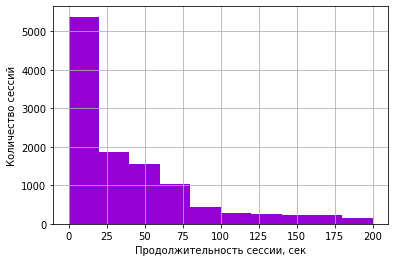
<div style="text-align: center">Рис. №1. Распределение продолжительности сессий по выборке</div>

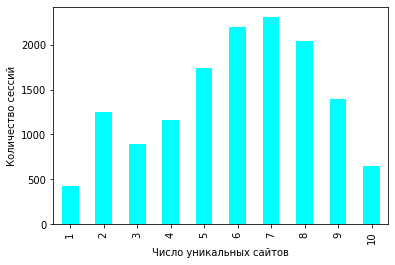
<div style="text-align: center">Рис. №2. Распределение числа уникальных сайтов за сессию по выборке</div>

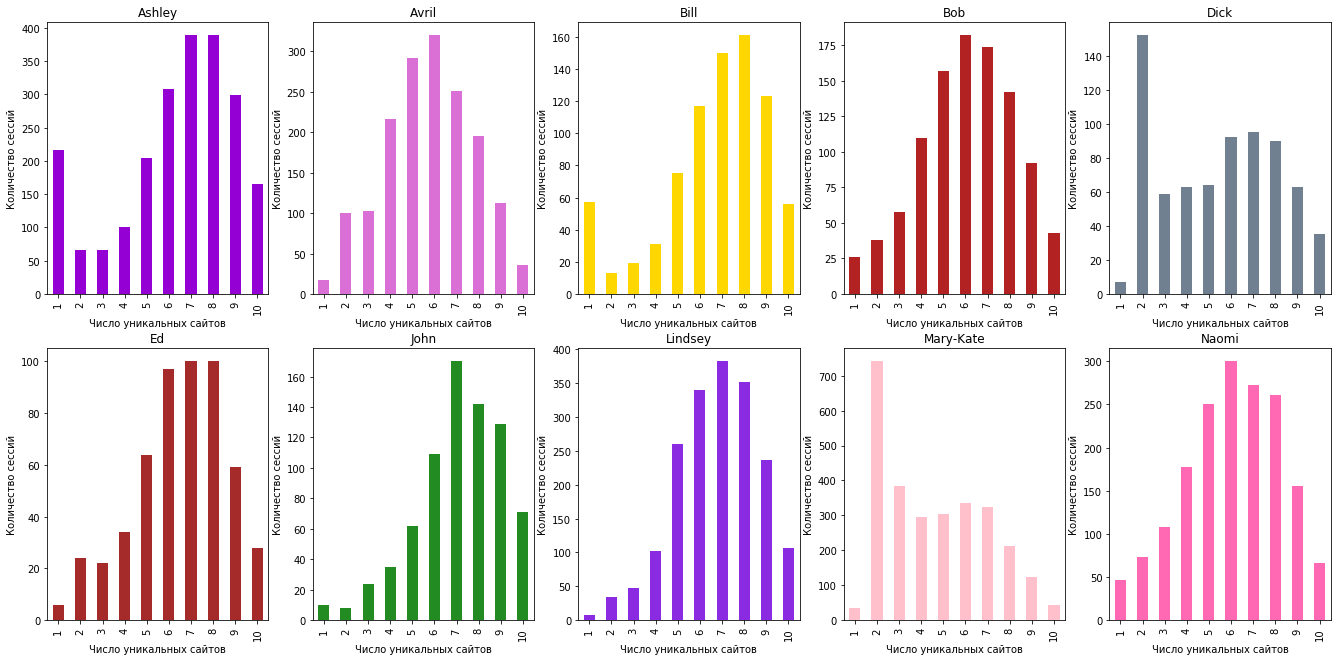
<div style="text-align: center">Рис. №3. Распределение числа уникальных сайтов за сессию для пользователей</div>

Как видим из последней гистограммы, разные пользователи имеют отличные друг от друга паттерны посещения сайтов. Как минимум, подобной характеристикой может являться число уникальных сайтов, посещённых за сессию.

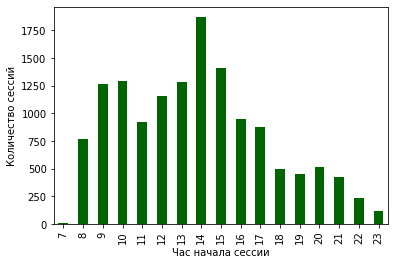
<div style="text-align: center">Рис. №4. Распределение часа начала сессии по выборке</div>

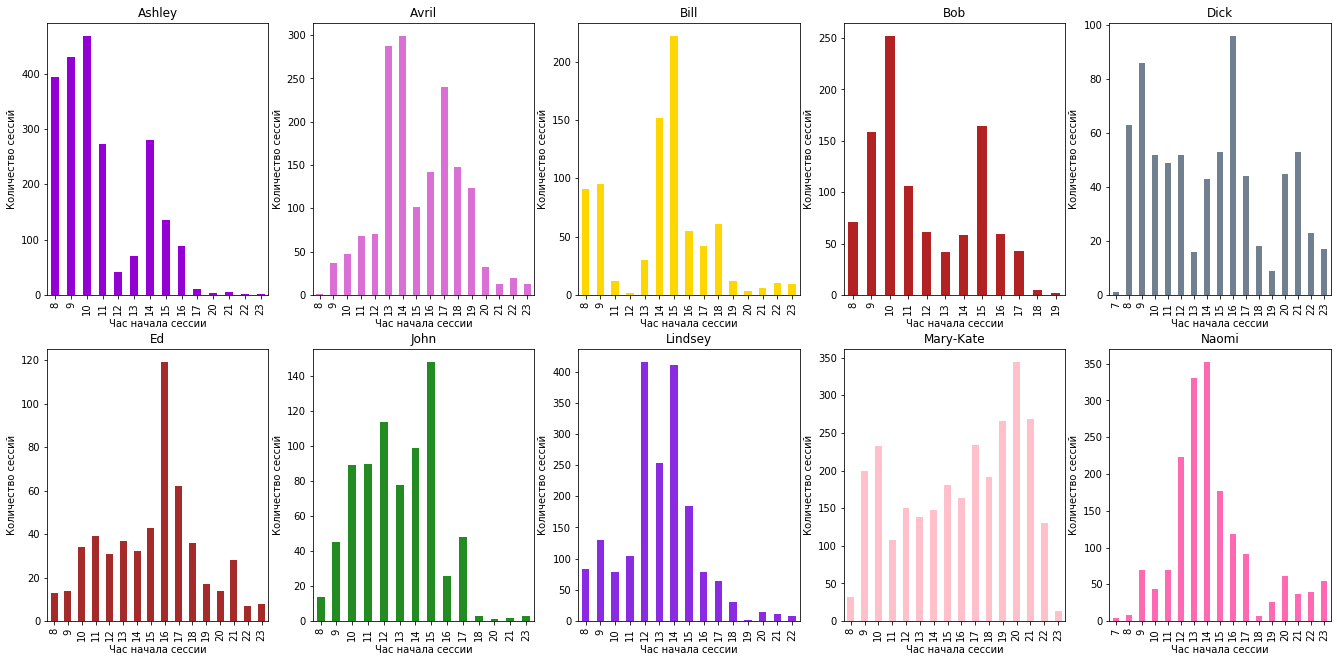
<div style="text-align: center">Рис. №5. Распределение часа начала сессии для пользователей</div>

Исходя из рисунка №5, также можно заключить, что час начала сессии может являться отличительной характеристикой для идентификации пользователей.

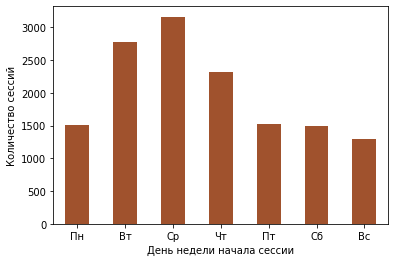
<div style="text-align: center">Рис. №6. Распределение дня недели начала сессии для пользователей</div>

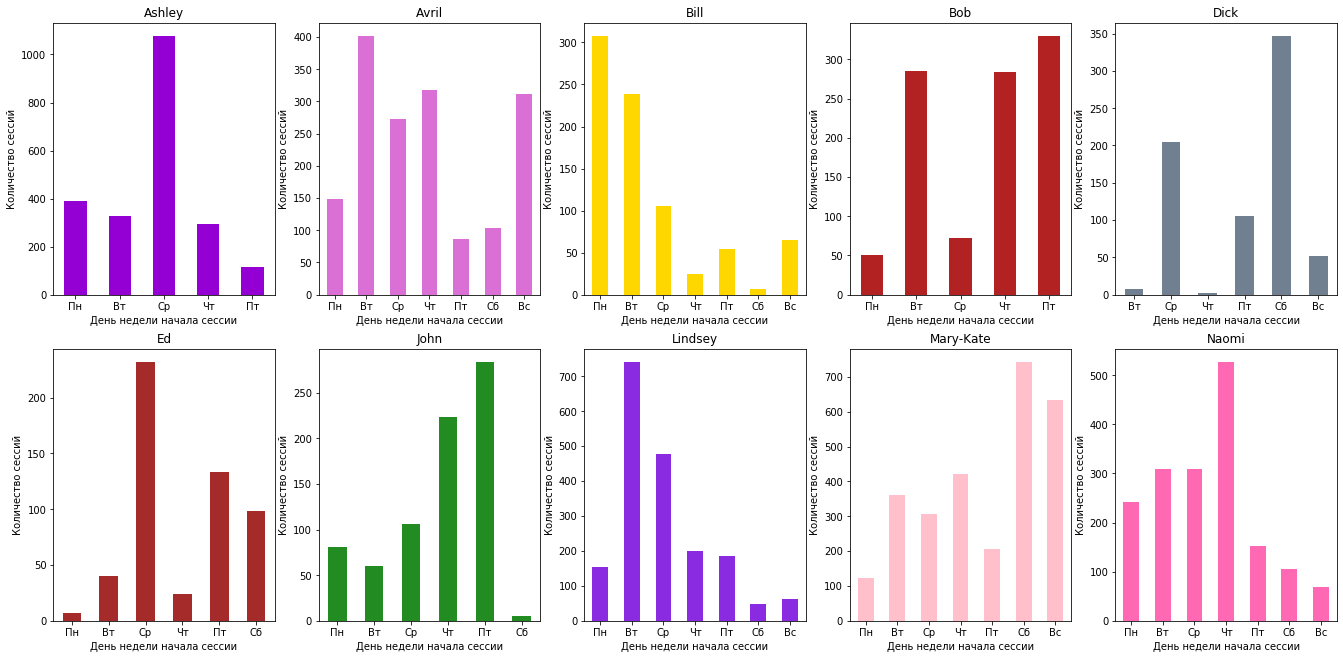
<div style="text-align: center">Рис. №7. Распределение дня недели начала сессии для пользователей</div>

Рисунок №7 свидетельствует о том, что день недели начала сессии также может являться отличительной характеристикой для идентификации пользователей.

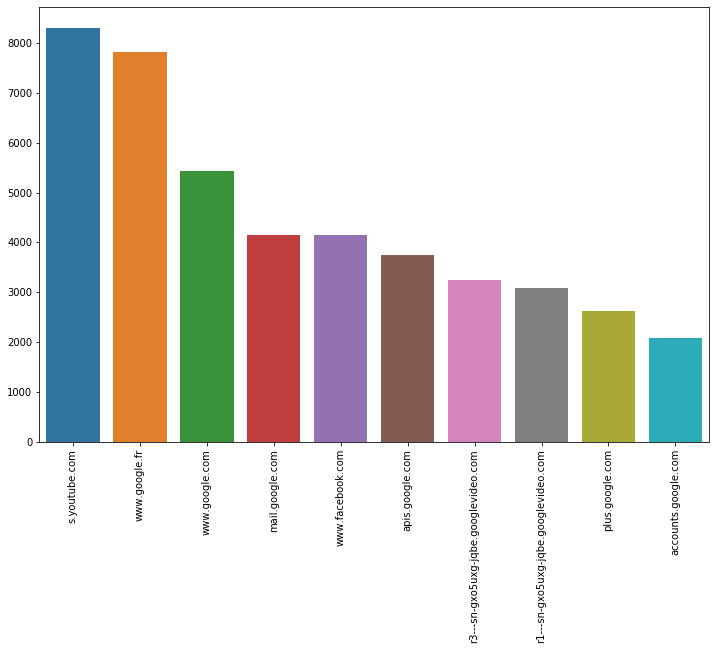
<div style="text-align: center">Рис. №8. Количество переходов по наиболее популярным сайтам</div>

## 4. Построение дополнительных признаков

Также были построены следующие признаки: 
- Время суток начала сессии
- Число последовательных переходов в рамках одного сайта
- Стандартное отклонение времени переходов между ссылками за сессию

Если ожидание улучшения классификации от введения первого признака, в принципе, интуитивно понятно, то, вводя последние два признака, я руководствовался следующими соображениями:

- Большое число последовательных переходов в рамках одного сайта может характеризовать неусидчивых пользователей.
- Высокое STD времени переходов между ссылками может свидетельствовать о том, что реальная длина (физической) сессии для пользователя характерно меньше 10-и.

Далее приведены гистограммы распределения этих признаков.

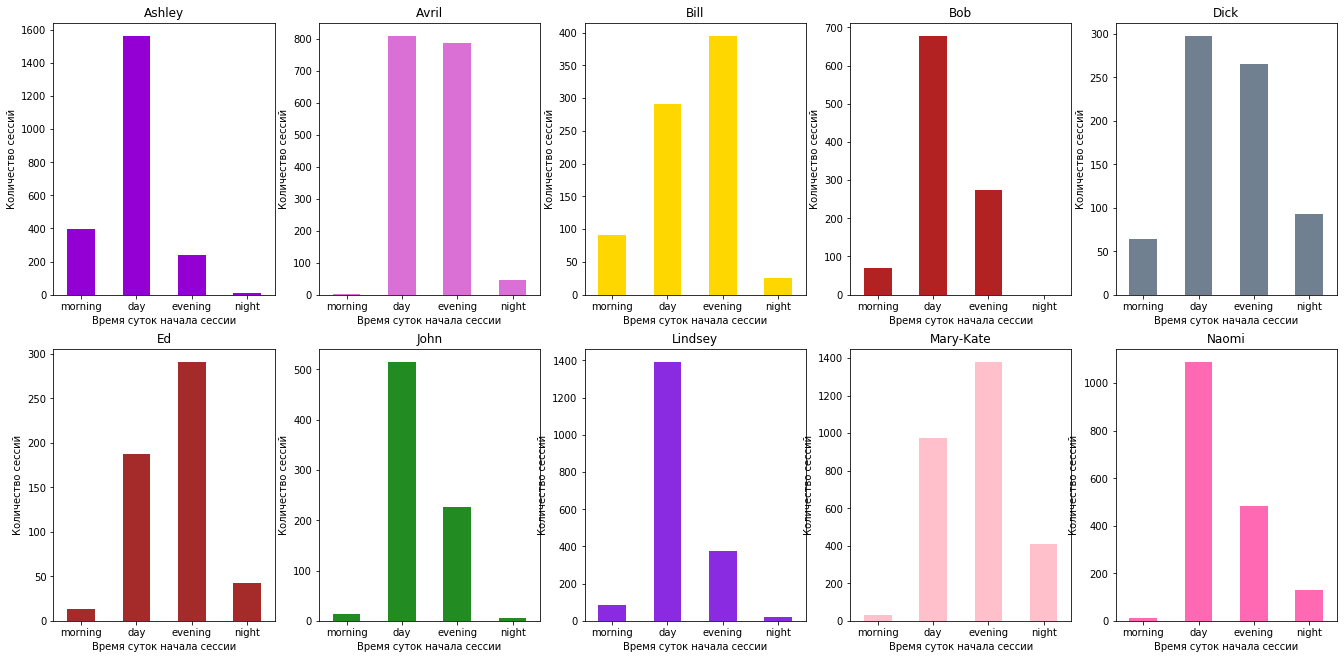
<div style="text-align: center">Рис. №9. Распределение времени суток начала сессии для пользователей</div>

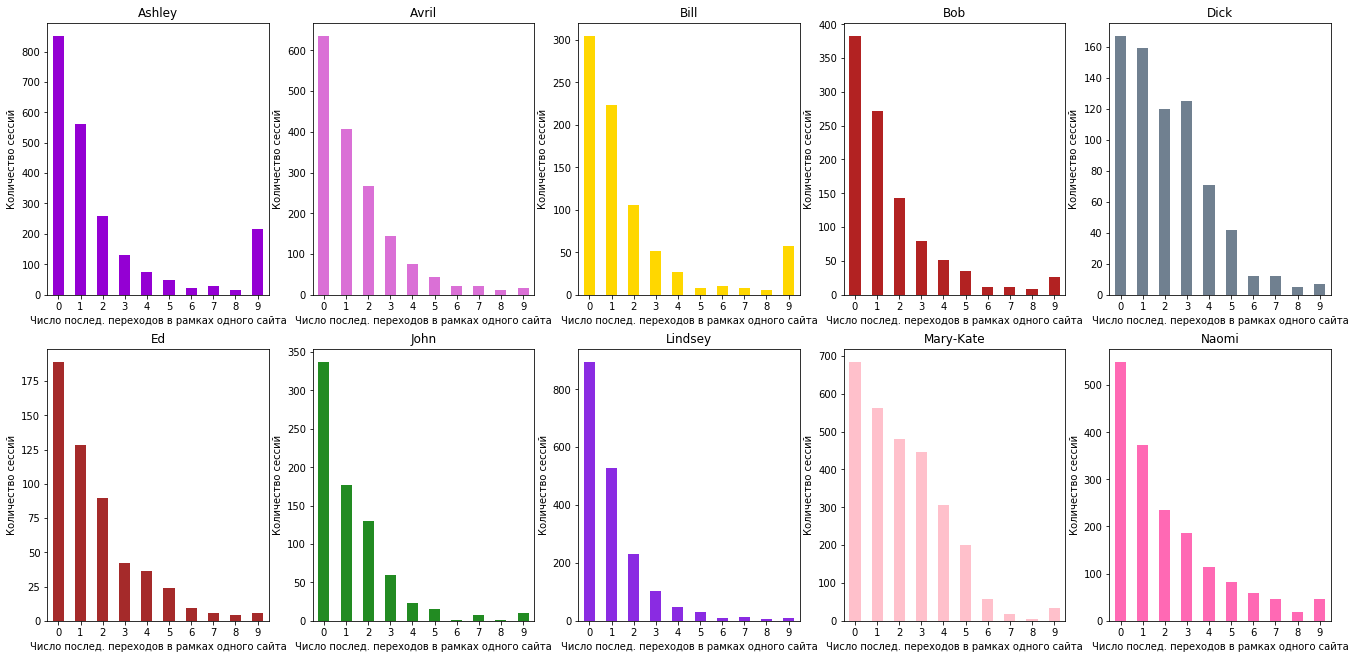
<div style="text-align: center">Рис. №10. Распределение количества последовательных переходов в рамках одного сайта для пользователей</div>

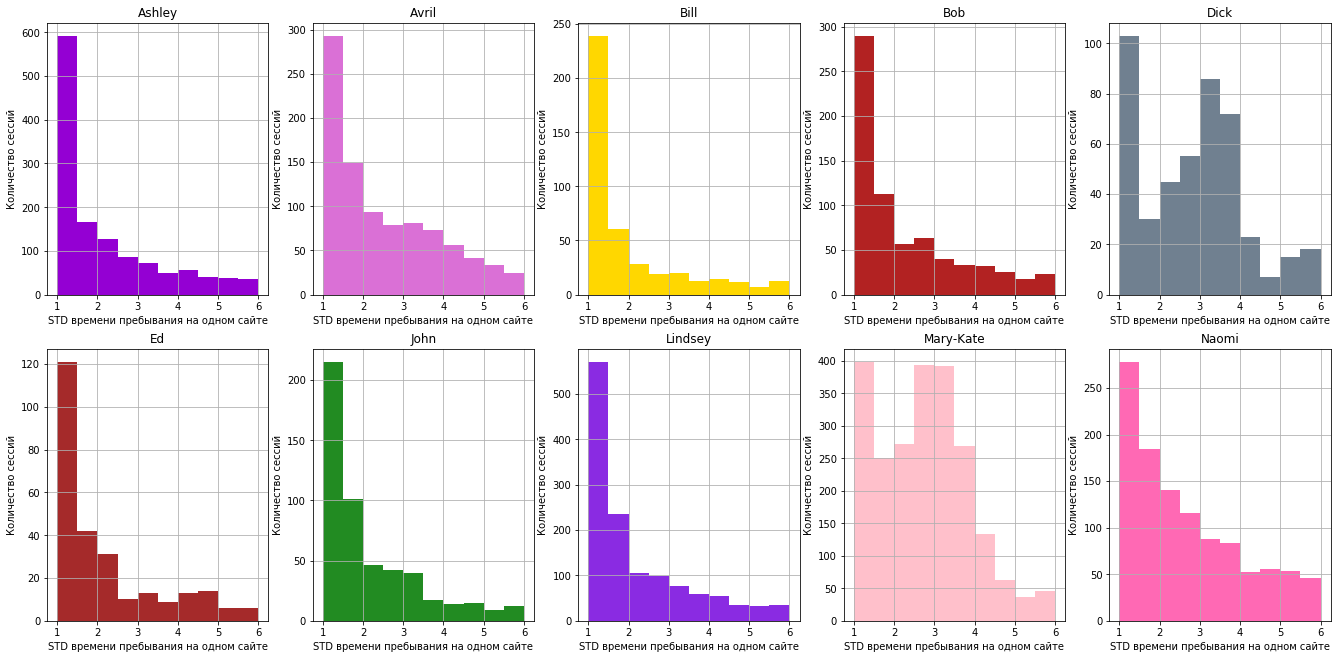
<div style="text-align: center">Рис. №11. Распределение STD времени переходов между ссылками за сессию для пользователей</div>

Как можно видеть, построенные признаки вполне могут улучшить качество классификации, поскольку имеют распределения, вид которых варьируется от пользователя к пользователю.

## 5. Сравнение алгоритмов классификации

Было проведено сравнение нижеперечисленных алгоритмов классификации на сессиях из 10 сайтов по метрике <b><i>accuracy</i></b>:
- KNeighborsClassifier со 100 ближайшими соседями
- RandomForestClassifier из 100 деревьев
- LogisticRegression с гиперпараметром `C`, обратным интенсивности регуляризации
- LinearSVC с гиперпараметром `C`, обратным интенсивности регуляризации

Метрика считалась сначала на стратифицированной 3-х кратной кроссвалидации, а затем на отложенной выборке.

Также был произведён подбор вышеобозначенных гиперпараметров для двух последних алгоритмов.

Наилучшие результаты показали также они. Приведём для них кривые валидации.

### LogisticRegression

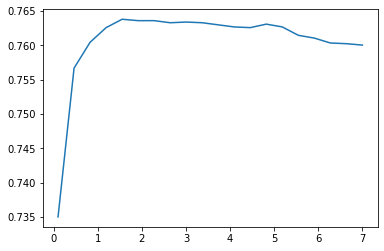
<div style="text-align: center">Рис. №12. Зависимость точности классификации LogisticRegression на кроссвалидации от гиперпараметра C</div>

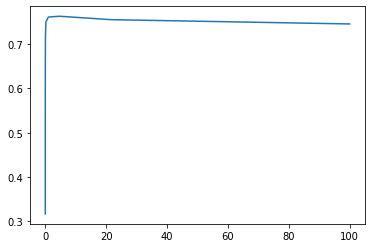
<div style="text-align: center">Рис. №13. Зависимость точности классификации LogisticRegression на кроссвалидации от гиперпараметра C</div>

### LinearSVC

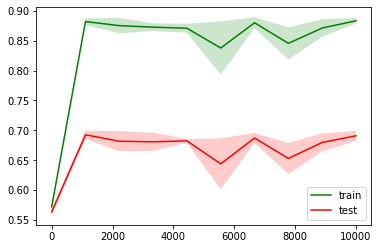
<div style="text-align: center">Рис. №14. Зависимость точности классификации LinearSVC от гиперпараметра C</div>

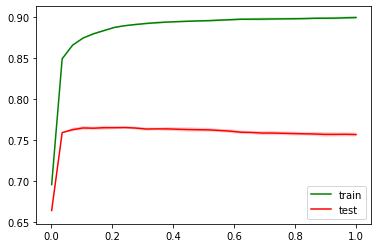
<div style="text-align: center">Рис. №15. Зависимость точности классификации LinearSVC от гиперпараметра C</div>

### Подбор параметров формирования выборки

Был проведён подбор оптимальных длины сессии и ширины скользящего окна для формирования обучающей выборки. Максимизировалась метрика <b><i>accuracy</i></b> на вышеупомянутой кроссвалидации; для оценки использовался алгоритм LinearSVC.

Так, для данных из 10 пользователей наиболее оптимальными значениями оказались 15 и 5 для длины сессии и ширины окна соответственно.

Для данных из 150 пользователей наиболее оптимальными оказались значения 10 и 10.

### Идентификация конкретного пользователя

Для данных из 150 пользователей с оптимальными параметрами длины сессии и окна была проведена идентификация каждого конкретного пользователя по отдельности. Максимизировалась метрика <b><i>accuracy</i></b> на вышеупомянутой кроссвалидации; для оценки использовался алгоритм LogisticRegression.

Качество алгоритма оказалась лучше константного прогноза для 121 юзеров из 150.

В качестве примера, кривая обучения для пользователя с ID=128:

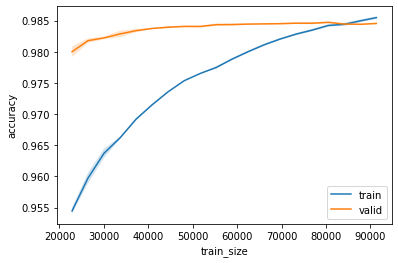
<div style="text-align: center">Рис. №16. Кривая обучения для ovr-классификации логистической регрессии для пользователя с ID=128</div>

## 6. Соревнования Kaggle

Для этих соревнований были использованы данные, предоставленные их организаторами (см. часть №2).

### Формат данных
Признаки для обучения были преобразованы в формат CSR, где индекс строки соответствовал номеру сессии, а индекс столбца &mdash; номеру признака.

Для описания наличия сайтов в сессии был использован подход "мешка слов", то есть порядок следования сайта в сессии игнорировался.

Факт наличия определённого сайта с ID `site_ID` в конкретной сессии `session_ID` обозначался единицей по индексам `(session_ID,site_ID)` в CSR-матрице; соответственно, отсутствие определённого сайта неявно обозначалось нулём по соответствующим индексам. Таким образом, непосредственная информация о посещении сайтов описывалась количеством признаков, равным числу уникальных сайтов в обучающей выборке.

Дополнительные признаки были представлены последними столбцами CSR-матрицы. Кодировались они следующим образом:
- <b>Категориальныe признаки</b><br>
  Для каждого из них формировалось количество бинарных признаков&mdash;индикаторов, равных числу уникальных значений в категории.
- <b>Континуальные признаки</b><br>
  Они переносились в матрицу без изменений.

### Cоревнование "Catch Me If You Can"

В данном соревновании использовалась метрика `ROC AUC`.

В качестве рабочего агоритма был использован SGDClassifier с логистической функцией потерь.

Обученный на всём тренировочном датасете без добавления дополнительных признаков (была использована информация исключительно о посещённых сайтах), алгоритм побил бенчмарк `sgd_logit_benchmark.csv` на публичной части рейтинга в соревновании.

Добавление таких фич, как `часть суток начала сессии`, `количество последовательно посещённых сайтов за сессию` и `STD времени пребывания на сайтах за сессию` ухудшило качество модели.

Тем не менее отказ от последних двух дополнительных фич привёл к улучшению предсказывающей способности модели так, что был побит бенчмарк `Logit +3 features`. Часть суток вычислялась следующим образом: интервал 21-03 считался ночью, 03-09 &mdash; утром, 09-15 &mdash; днём, 15-21 &mdash; вечером.

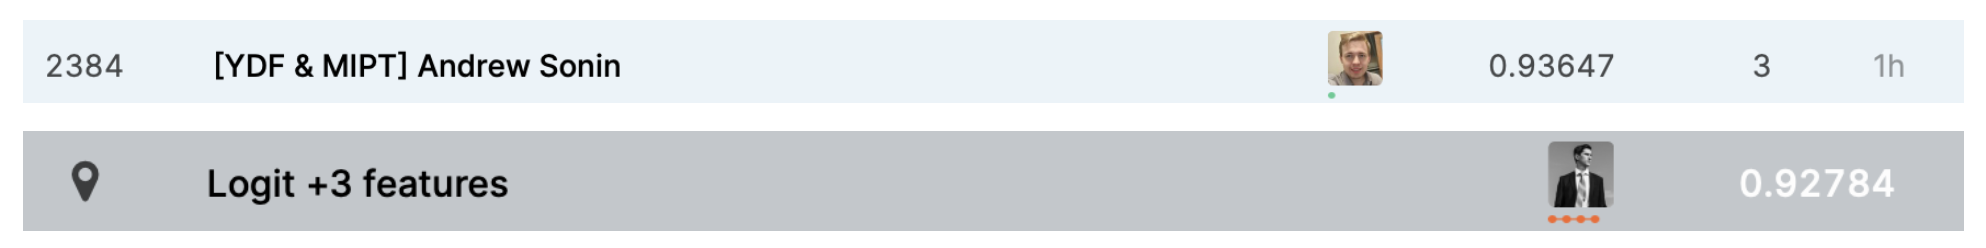

### Соревнование "Identify Me If You Can"

В данном соревновании использовалась метрика `accuracy`.

В качестве рабочих алгоритмов тестировались:
- Vowpal Wabbit
- SGDClassifier с логистической функцией потерь
- LogisticRegression

Данные преобразовывались аналогично предыдущему соревнованию без добавления дополнительных признаков.

Обученные на всех предоставленных тренировочных данных, алгоритмы показали следующее качество:
```
- Vowpal Wabbit:       0.183
- SGDClassifier:       0.198
- LogisticRegression:  0.199
```
В принципе, можем заключить, что задача классификации на 400 классов решается недостаточно хорошо при честном отделении по времени тестовой выборки от обучающей.

## 7. Итоги

- Было проведено ознакомление с техникой составления обучающей выборки.
- Был изучен CSR-формат матриц, позволяющий компактно хранить в памяти матрицы с большим количеством нулей.
- Было проведено сравнение алгоритмов классификации. Наилучшим оказалась логистическая регрессия.
- Было проведено ознакомление с техникой добавления дополнительных признаков.
- Было принято участие в двух Kaggle-соревнованиях. Добавлением одного категориального признака было побито два бенчмарка в соревновании "Catch Me If You Can".
- Было проведено ознакомление с практическим применением библиотеки Vowpal Wabbit.

## 8. Выводы

- Использование формата CSR даёт возможность экономить память при хранении разреженных матриц, а также позволяет радикально ускорить как формирование обучающей выборки, так и обучение алгоритмов классификации.
- Наилучшим алгоритмом классификации для данных задач оказалась логистическая регрессия с нестохастическим градиентным спуском, хотя и время её обучения получилось на 2 порядка больше, чем при использовании SGD. Библиотека Vowpal Wabbit показалала худшие результаты, по сравнению с логистической регрессией как с SGD, так и с обычным GD.
- Добавление дополнительных признаков может как улучшить качество классификации, так его и ухудшить. Дополнительные признаки лучше выбирать осмысленно таким образом, чтобы содержащаяся в них информация минимально пересекалась с информацией, хранящейся в уже имеющихся признаках.
- Качество построенной модели оказалось хорошим при бинарной классификации конкретного пользователя против всех (метрика `ROC AUC` стабильно больше 0.9), в то время как точность определения конкретного пользователя среди нескольких сотен других оставляет желать лучшего (`accuracy` меньше 0.2).
- На практике построенные модели можно применять для улучшения качества доставки таргетинговой рекламы в частности и для общего улучшения качества рекомендательных интернет-систем в общем.
- Для дальнейшего улучшения построенных моделей можно подобрать большее количество осмысленных дополнительных признаков, использовать стэкинг, а также попробовать некоторые другие алгоритмы классификации (например, для бинарной классификации может подойти использование автоэнкодера).